In [349]:
import numpy as np
from numba import njit

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import time

from scipy.optimize import curve_fit

For this problem, I wanted to try the [sieve of Eratosthenes](https://en.wikipedia.org/wiki/Sieve_of_Eratosthenes). This is more efficient than just iterating over all numbers and checking divisibility. 

In [350]:
@njit
def get_N_primes(N):
    '''
    N (int > 1): how many of the first prime numbers to return.
    '''
    
    sieve = np.full(N+1, True)
    
    i = 2
    while (i * i <= N):
        if sieve[i]:
            for j in range(i*i, N+1, i):
                sieve[j] = False
        i += 1
    return sieve    

In [351]:
def get_N_primes_no_njit(N):
    '''
    N (int > 1): how many of the first prime numbers to return.
    '''
    
    sieve = np.full(N+1, True)
    
    i = 2
    while (i * i <= N):
        if sieve[i]:
            for j in range(i*i, N+1, i):
                sieve[j] = False
        i += 1
    return sieve    

First test: find the number of primes between 0 and 100, and check they are correct. These results look good.

In [354]:
sieve = get_N_primes(100)
for i in range(2, 100+1):
        if sieve[i]:
            print(i)
print(f'Number of primes between 0 and 100: {np.sum(sieve)-2}')

2
3
5
7
11
13
17
19
23
29
31
37
41
43
47
53
59
61
67
71
73
79
83
89
97
Number of primes between 0 and 100: 25


Now, for fun, let's compare the speed of the code with and without `numba`. We can clearly see that just adding a decorator makes quite a difference.

In [355]:
times_njit = []
times_no_njit = []
for N in range(2, 10000):
    t0_njit = time.time()
    get_N_primes(N)
    t1_njit = time.time()
    
    t0_no_njit = time.time()
    get_N_primes_no_njit(N)
    t1_no_njit = time.time()
    
    times_njit.append(t1_njit - t0_njit)
    times_no_njit.append(t1_no_njit - t0_no_njit)

Text(0.5, 0.98, 'Comparison of time complexity')

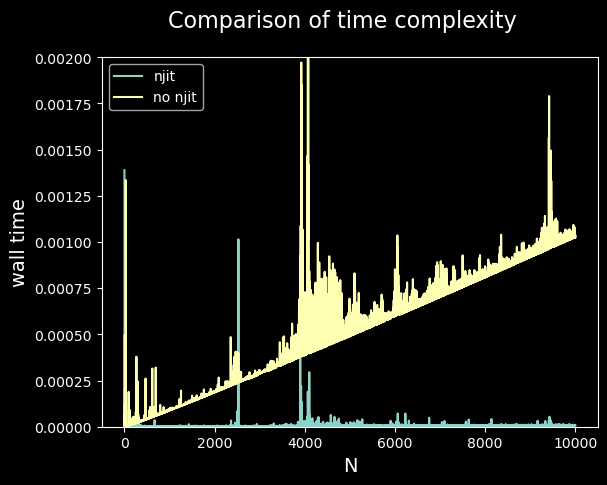

In [356]:
fig, ax = plt.subplots()
x_axis = np.arange(2, 10000)

ax.plot(x_axis, times_njit, label='njit')
ax.plot(x_axis, times_no_njit, label='no njit')

ax.legend()

ax.set_xlabel('N', fontsize=14)
ax.set_ylabel('wall time', fontsize=14)
ax.set_ylim(0, 0.002)

fig.suptitle('Comparison of time complexity', fontsize=16)

/var/folders/gl/qkjlxgd944l2rvbjy6m3dk900000gr/T/ipykernel_55613/266668484.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 0.002)


Text(0.5, 0.98, 'Comparison of time complexity (log scale)')

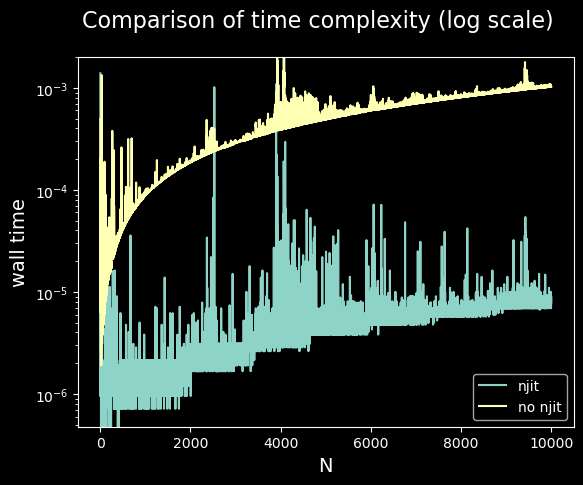

In [357]:
fig, ax = plt.subplots()
x_axis = np.arange(2, 10000)

ax.plot(x_axis, times_njit, label='njit')
ax.plot(x_axis, times_no_njit, label='no njit')

ax.set_yscale('log')
ax.legend()

ax.set_xlabel('N', fontsize=14)
ax.set_ylabel('wall time', fontsize=14)
ax.set_ylim(0, 0.002)

fig.suptitle('Comparison of time complexity (log scale)', fontsize=16)

I read that the sieve of Eratosthenes has $\mathcal{O}(n \log \log n)$ complexity, so let's quickly try a fit to get the prefactor and see if it describes the code well. I do this with the optimized code.

In [358]:
times_njit = []
for N in range(2, 100000):
    t0_njit = time.time()
    get_N_primes(N)
    t1_njit = time.time()

    times_njit.append(t1_njit - t0_njit)

In [359]:
def time_complexity(N, a):
    return a * N * np.log(np.log(N))

x_axis = np.arange(2, 100000)
popt, pcov = curve_fit(time_complexity, x_axis, times_njit)

print(f'Amplitude {popt[0]} with error {pcov[0][0]}')

Amplitude 3.324358607590905e-10 with error 2.1777226583292606e-26


/var/folders/gl/qkjlxgd944l2rvbjy6m3dk900000gr/T/ipykernel_55613/3649023476.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 0.002)


Text(0.5, 0.98, 'Comparison of time complexity (log scale)')

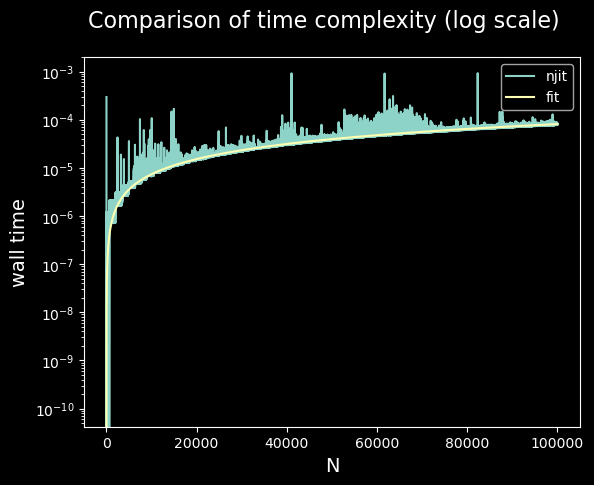

In [360]:
fig, ax = plt.subplots()

ax.plot(x_axis, times_njit, label='njit')
ax.plot(x_axis, time_complexity(x_axis, popt[0]), label='fit')

ax.set_yscale('log')
ax.legend()

ax.set_xlabel('N', fontsize=14)
ax.set_ylabel('wall time', fontsize=14)
ax.set_ylim(0, 0.002)

fig.suptitle('Comparison of time complexity (log scale)', fontsize=16)

This looks good. Some spikes are expected, but the overall trend seems to agree with the theoretical asymptotic complexity.

In [361]:
sieve = get_N_primes(100000000)
print(f'Number of primes found: {np.sum(sieve)-2}')

Number of primes found: 5761455


In [362]:
primes = np.nonzero(sieve)[0][2:]

It turns out that if you plot all prime numbers in polar coordinates, you get interesting spirals. Each prime number $p$ is represented as $(p, p)$ in $(r, \theta)$ coordinates. Here I show the first 1000 primes. Notice there's two prominent gaps. 

This was inspired by a 3Blue1Brown video I watched a long time ago in high school: https://www.youtube.com/watch?v=EK32jo7i5LQ

Text(0.5, 0.98, 'Prime Spiral')

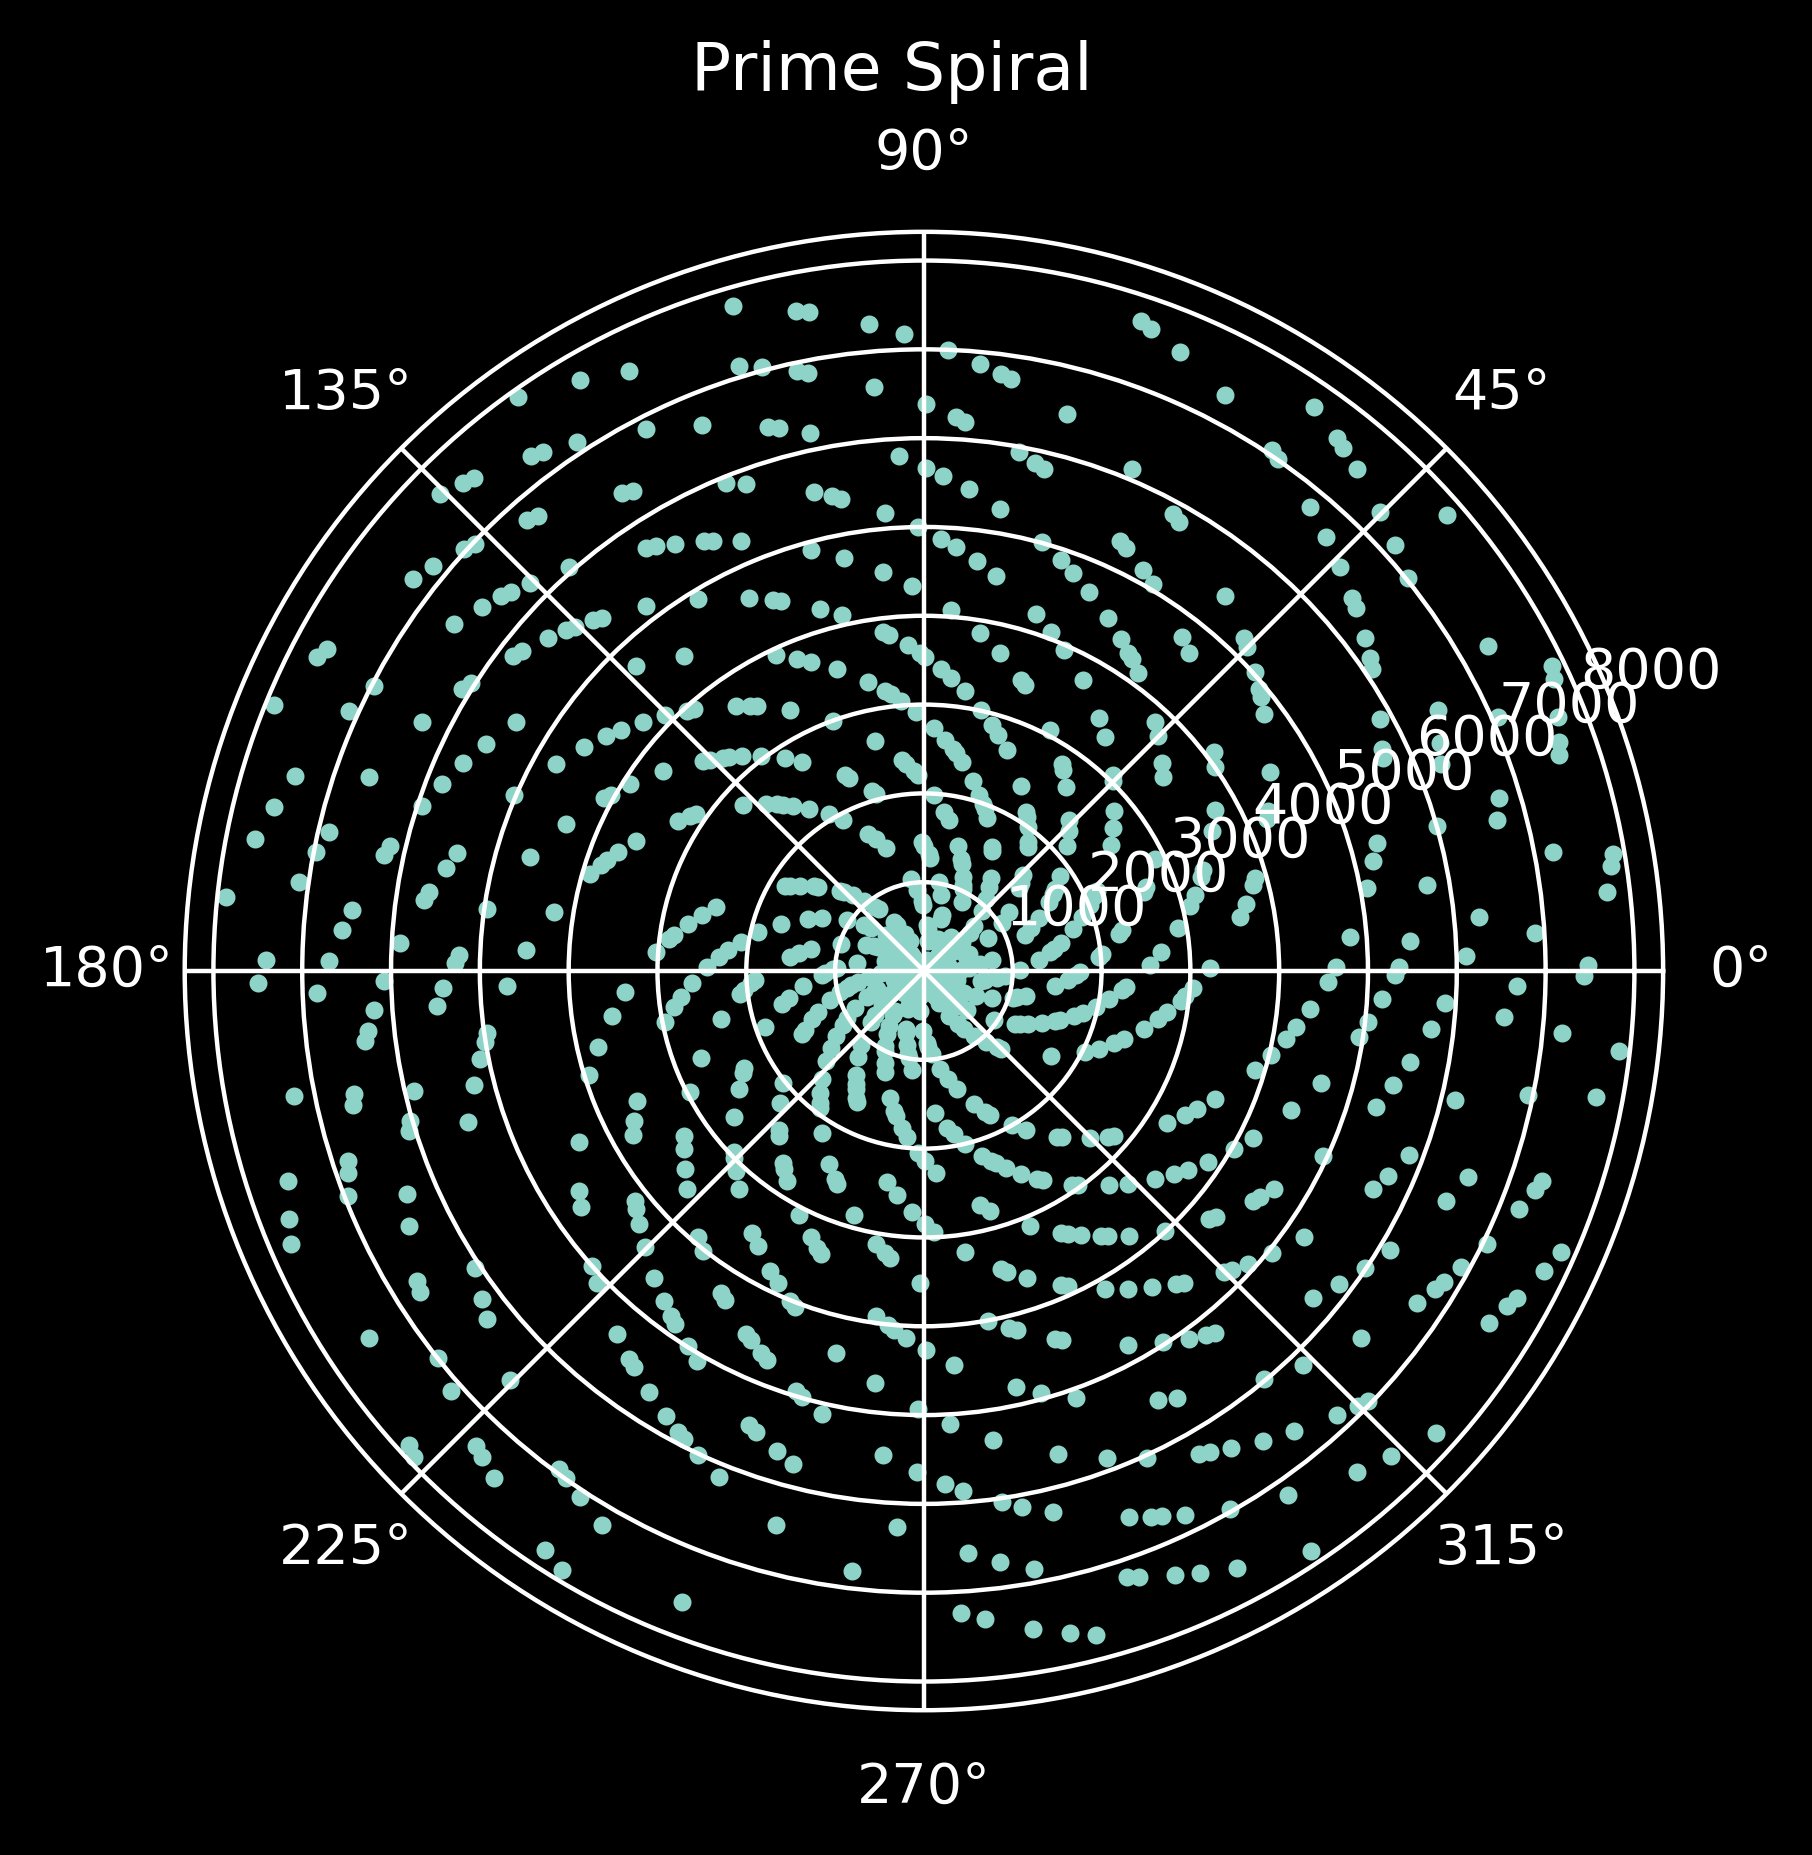

In [347]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, dpi=400)
ax.scatter(primes[:1001], primes[:1001], s=5)

fig.suptitle('Prime Spiral')

Finally, to actually answer the original homework question, let's get the first 10,000 primes. Since we already have over 5 million, we can just slice the array we already generated. 

In [373]:
first_tenk_primes = primes[:10001]
first_tenk_primes

array([     2,      3,      5, ..., 104723, 104729, 104743])

Or we can grab the first 1 million:

In [374]:
first_million_primes = primes[:1000001]
first_million_primes

array([       2,        3,        5, ..., 15485857, 15485863, 15485867])